# Exercise 3

We generate the same noisy dataset as last time:

In [3]:
import numpy as np

np.random.seed(0)
n_samples = 1000
X = np.random.rand(n_samples)*10
X = np.expand_dims(X, axis=-1)
noise = np.random.randn(n_samples)*4.0
noise = np.expand_dims(noise, axis=-1)
ground_truth = 5 * X + 3
y = ground_truth + noise

X and y are the features and the label, respectively. We can look at the format of the data:

In [4]:
print(type(X))
print(type(y))

print(X.shape)
print(y.shape)

print(X.dtype)
print(y.dtype)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1000, 1)
(1000, 1)
float64
float64


## Plotting the data

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

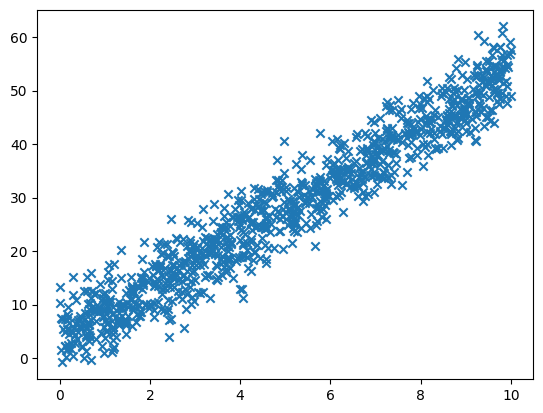

In [6]:
plt.figure()
plt.scatter(X, y, marker="x")
plt.show()

## Implementing Gradient Descent

We add an additional column for the bias to the dataset:

In [7]:
X_ = np.c_[X, np.ones((X.shape[0]))]

We initialize a weight matrix with random values:

In [8]:
num_samples = X_.shape[0]
num_features = X_.shape[1]

np.random.seed(42)
initial_weights = (np.random.rand(num_features).reshape(-1, 1) * 2 - 1) / np.sqrt(num_features)
weights = initial_weights.copy()

As in the previous exercise, we can implement gradient descent in the following way:

In [9]:
losses = []
LR = 0.001
for i in range(1, 301):
    prediction = X_ @ weights
    # Calculate loss
    error = y - prediction
    L = np.square(error).sum()/num_samples
    # Calculate the gradient
    gradient = -2.0/num_samples * X_.T @ (y - prediction)
    # Update weights
    weights -= LR * gradient
    
    losses.append(L.item())

In [10]:
print(weights)
print("Final loss:", L)

[[5.20224084]
 [1.71488875]]
Final loss: 15.573018723195977


We can plot how the loss develops:

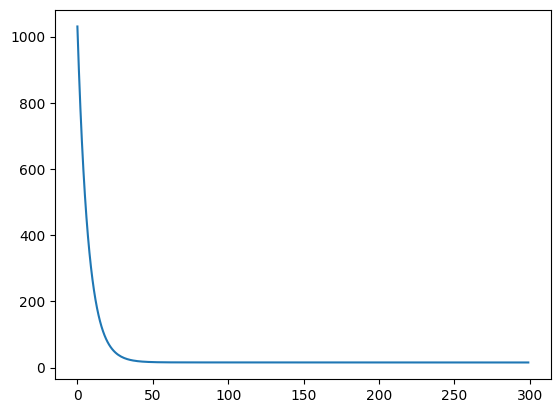

In [11]:
plt.plot(losses)
plt.show()

We can dump this loss curve to a file using the `pickle` module. This allows us to easily load it in another notebook later on (See `exercise3_optimizers_comparision.ipynb`).

In [12]:
import pickle
with open("gd.pickle", "wb") as f:
    pickle.dump(losses, f)

## Stochastic Gradient Descent

But in practise, we seldom use vanilla gradient descent, as it operates on the whole dataset at once, and most datasets we encounter today are way too big to fit into memory at once. To avoid that, we can use mini-batch / stochastic gradient descent, which operates on individual batches of data, not the whole dataset at once.

The following is some code that simulates loading the dataset in chunks, instead of the whole array. In practise, one can rarely use the whole dataset in the loss and gradient calculations, as we did it in the first two exercises (real datasets are usually too big to fit into system memory entirely). The code splits the dataset into batches of size `BATCH_SIZE`. The function `Loader` constructs a so-called generator, which means that the returned object is iterable and can be used to obtain batches iteratively, until all batches have been `yield`ed. A simple way to think about it is that `yield` acts similar to `return`, only that the function basically halts execution after the `yield`, until you want the next element from the generator, which is when the code execution continues. If you are new to this concept, you can read up on the topic of generators in a Python tutorial, or skip it for this exercise, since the generator functionality is already implemented here and the notebook contains code that shows how this function is used in the training loop. All you need to know for now is that you can obtain batches from the generator using a for loop.

In [13]:
from math import ceil

BATCH_SIZE = 100
NUM_BATCHES = int(ceil(float(num_samples)/BATCH_SIZE))

def Loader():
    # This generates the batches, one after another
    # For a large dataset, we could load data from disk here
    for i in range(NUM_BATCHES):
        # Get the i'th slice of data
        batch_X = X_[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch_y = y[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        yield batch_X, batch_y

Using this, we can implement our stochastic gradient algorithm:

In [14]:
weights = initial_weights.copy()

losses = []
LR = 0.001
for epoch in range(1, 301):
    total_loss = 0
    
    # Here we get a new batch of data in every iteration
    # batch_X are the X values, and batch_y are the target values (labels)
    for batch_X, batch_y in Loader():
        # This is the number of data points in the batch (usually equal to BATCH_SIZE, but could be less for the last batch)
        num_batch_samples = len(batch_y)
        
        # This portion of the code is similar to normal (batch) gradient descent, but we use batch_X and batch_y instead of X_ and y
        prediction = batch_X @ weights
        error = batch_y - prediction
        L = np.square(error).sum()/num_batch_samples
        gradient = -2.0/num_batch_samples * batch_X.T @ (batch_y - prediction)
        
        weights -= LR * gradient
        
        total_loss += L.item()*num_batch_samples
    
    # Calculate the loss for the whole dataset (by weighted summation over the losses of all batches)
    epoch_loss = total_loss/num_samples
    if epoch == 1 or epoch % 100 == 0:
        print(f"epoch {epoch} loss: {epoch_loss}")
    losses.append(epoch_loss)
    
print(weights)

epoch 1 loss: 601.2516318539647
epoch 100 loss: 15.255531859261907
epoch 200 loss: 15.05056002042228
epoch 300 loss: 14.975161763331407
[[5.02278236]
 [2.89529553]]


Again, we can plot the loss:

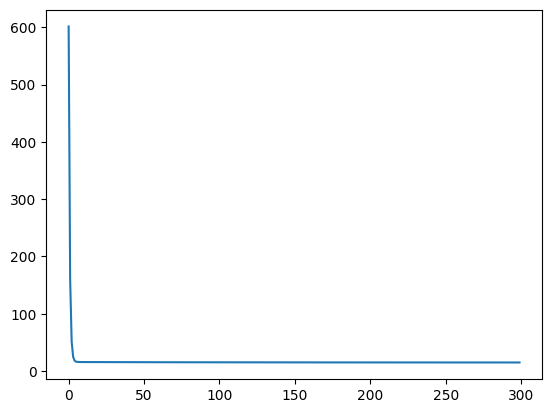

In [15]:
plt.plot(losses)
plt.show()

We see that the loss is decreasing much faster than with (batch) gradient descent (GD). This is because mini-batch gradient descent (SGD) can perform multiple gradient steps in one epoch (one pass over the dataset), instead of just one with GD. As long as the batch size is large enough to capture an approximation of the statistics of the dataset, SGD can converge in fewer epochs than GD, because it can perform multiple weight updates in a single epoch.

Again, we dump the loss curve data to a pickle file, so that we can see it in the comparison notebook:

In [16]:
import pickle
with open("sgd.pickle", "wb") as f:
    pickle.dump(losses, f)